In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/NEN5060-2018.xlsx


In [2]:
!pip install gekko

     |████████████████████████████████| 9.8 MB 4.0 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO
import pandas as pd
import math
from pathlib import Path
import os

> ## **qsun Calculates the irradiation on a outer surface**
 
         SYNTAX: E=irrad(Dh,En,iday,LST,gamma,beta,rground)
         OUTPUT: global irradiation on a surface
         
Splitted irradiation

         E(1)= diffuse solar irradiation on an inclined surface
         E(2)= direct solar irradiation on an inclined surface
         E(3)= total solar irradiation on an inclined surface
         E(4)= total solar irradiation on a horizontal surface

INPUT:

        (scalar) Dh = diffuse horizontal irradiation[W/m2]
        (scalar) En = direct normal irradiation [W/m2]
        (scalar) t = time seconds after midnight 1 january
        (scalar) gamma = azimuth angle of the surface,
        east:gamma = -90, west:gamma = 90
        south:gamma = 0, north:gamma = 180
        (scalar) beta = inclination angle of the surface,
        horizontal: beta=0, vertical: beta=90
        default geographical position: De Bilt
        default ground reflectivity (albedo): 0.2
 
EXAMPLE: E=irrad(800,200,201,12,0,45)
ANSWER: E=1.0e+003 *
0.8569 0.1907 1.0759 0.9684

REF: Perez (zie Solar Energy volume 39 no. 3)

Adapted version from Eindhoven University of Technology: JvS feb 2002

In [4]:
def qsun(tclim,
        Dh,
        En,
        gamma,
        beta,
        rground):
    #(scalar) iday = day of the year (1-365)
    #(scalar) LST = Local Standard time (0 - 24) [hour]

    
        iday = 1+math.floor(tclim/(24*3600))
        LST  = math.floor((tclim/3600) % 24)
        # L = Latitude [graden]
        L    = 52.1
        # LON = Local Longitude [graden] oost is positief
        LON  = 5.1
        # LSM = Local Standard time Meridian [graden] oost is positief
        LSM  = 15
        # rground = albedo
        # rground=0.2;
        r    = math.pi/180;
        L    = L*r
        beta = beta*r
        theta= 2*math.pi*(iday-1)/365.25
        el   = 4.901+0.033*math.sin(-0.031+theta)+theta
        # declination

        delta= math.asin(math.sin(23.442*r)*math.sin(el))
        q1   = math.tan(4.901+theta)
        q2   = math.cos(23.442*r)*math.tan(el)
        # equation of time

        ET   = (math.atan((q1-q2)/(q1*q2+1)))*4/r
        AST  = LST+ET/60-(4/60)*(LSM-LON)
        h    = (AST-12)*15*r
        # hai=sin(solar altitude)
        hai  = math.cos(L)*math.cos(delta)*math.cos(h)+math.sin(L)*math.sin(delta)
        
       
        E    = np.zeros((1,4))
        
        if hai>0:
            # salt=solar altitude

            salt= math.asin(hai)
            phi = math.acos((hai*math.sin(L)-math.sin(delta))/(math.cos(salt)*math.cos(L)))*np.sign(h)
            gam = phi-gamma*r;
            # cai=cos(teta)
            cai = math.cos(salt)*math.cos(abs(gam))*math.sin(beta)+hai*math.cos(beta)
            # teta = incident angle on the tilted surface
            teta= math.acos(cai)
            # salts=solar altitude for an inclined surface

            salts=math.pi/2-teta
            # Perez (zie Solar Energy volume 39 no. 3)
            # berekening van de diffuse straling op een schuin vlak
            # Approximatin of A and C, the solid angles occupied by the circumsolar region,
            # weighed by its average incidence on the slope and horizontal respectively.
            # In the expression of diffuse on inclined surface the quotient of A/C is
            # reduced to XIC/XIH. A=2*(1-cos(beta))*xic, C=2*(1-cos(beta))*xih
            # gecontroleerd okt 1996 martin de wit

            # alpha= the half-angle circumsolar region
            alpha=25*r

            if salts<-alpha:

                xic=0

            elif salts>alpha:

                xic=cai

            else:
                xic=0.5*(1+salts/alpha)*math.sin((salts+alpha)/2)


            if salt>alpha:

                xih=hai

            else:
                xih=math.sin((alpha+salt)/2)


            epsint=[1.056 ,1.253 ,1.586, 2.134, 3.23 ,5.98, 10.08 ,999999]
            f11acc=[-0.011 ,-0.038 ,0.166 ,0.419 ,0.710 ,0.857 ,0.734 ,0.421]
            f12acc=[0.748 ,1.115 ,0.909 ,0.646 ,0.025 ,-0.370 ,-0.073 ,-0.661]
            f13acc=[-0.080 ,-0.109 ,-0.179 ,-0.262 ,-0.290 ,-0.279 ,-0.228 ,0.097]
            f21acc=[-0.048 ,-0.023 ,0.062 ,0.140 ,0.243 ,0.267 ,0.231 ,0.119]
            f22acc=[0.073 ,0.106 ,-0.021 ,-0.167 ,-0.511 ,-0.792 ,-1.180 ,-2.125]
            f23acc=[-0.024 ,-0.037 ,-0.050 ,-0.042 ,-0.004 ,0.076 ,0.199 ,0.446]
            
            # determination of zet = solar zenith angle (pi/2 - solar altitude).
            
            zet=math.pi/2-salt
            
            # determination of inteps with eps

            inteps=0

            if Dh>0:

                eps=1+En/Dh
                inteps=7     # give big random number for starting point
                for i in range(len(epsint)):
                    if epsint[i]>=eps:
                        temp_i =i        
                        inteps=min(temp_i,inteps)
                #print(inteps)
                
                #inteps=min(i)

            # calculation of inverse relative air mass

            airmiv=hai

            if salt<10*r:
                airmiv=hai+0.15*(salt/r+3.885)**(-1.253)   #change ^ to **
            # calculation of extraterrestrial radiation

            Eon=1370*(1+0.033*math.cos(2*math.pi*(iday-3)/365))
            
            #delta is "the new sky brightness parameter"

            delta=Dh/(airmiv*Eon)

            # determination of the "new circumsolar brightness coefficient
            # (f1acc) and horizon brightness coefficient (f2acc)"
            
            f1acc=f11acc[inteps]+f12acc[inteps]*delta+f13acc[inteps]*zet
            f2acc=f21acc[inteps]+f22acc[inteps]*delta+f23acc[inteps]*zet
            
            # determination of the diffuse radiation on an inclined surface

            E[0,0]=Dh*(0.5*(1+math.cos(beta))*(1-f1acc)+f1acc*xic/xih+f2acc*math.sin(beta))

            if E[0,0]<0:

                E[0,0]=0

            # horizontal surfaces treated separately
            # beta=0 : surface facing up, beta=180(pi) : surface facing down
            #3/22/19 10:05 AM E:\NEN5060\qsun.m 4 of 4
            
            if beta>-0.0001 and beta<0.0001:

                E[0,0]=Dh

            if beta>(math.pi-0.0001) and beta<(math.pi+0.0001):

                E[0,0]=0
                
             # Isotropic sky
             # E(1)=0.5*(1+cos(beta))*Dh;

             # direct solar radiation on a surface

            E[0,1]=En*cai

            if E[0,1]<0.0:

                E[0,1]=0

            # the ground reflected component: assume isotropic
            # ground conditions.

            Eg=0.5*rground*(1-math.cos(beta))*(Dh+En*hai)
            
            # global irradiation

            E[0,3]=Dh+En*hai

             # total irradiation on an inclined surface
            E[0,2]=E[0,0] + E[0,1] + Eg
            
        return E[0,2]

> ### Change working directory to input data file

In [5]:
print(Path.cwd())
#print(os.listdir("../kaggle/input"))
parent_dir = os.chdir('/kaggle/')
data_dir = Path.cwd() /'input'
#output_dir = Path.cwd()/'working'/'submit'
NENdata_path = data_dir/'NEN5060-2018.xlsx'
xls = pd.ExcelFile(NENdata_path)    

/kaggle/working


In [6]:
xls.sheet_names  # Check sheet names

['nen5060 - energie', 'ontwerp 1%', 'ontwerp 5%']

In [7]:
# select sheet k=1 by NEN default
k=1


> Exchange_NEN5060
>  
    Exchange of NEN5060 data in climate files for Python
    Exchange of NEN5060_2018 data in Excel
    for irradiation on S, SW, W, NW, N, NE, E, SE and horizontal and Toutdoor
    Irradiation can be used for solar irradiation on windows
    %Matlab version September 17th 2018 by Arie Taal THUAS (The Hague University of Applied Sciences)
    %Python version 28/05/2020 by Trung Nguyen HAN University of Applied Sciences

In [8]:
rground=0  #ground reflection is ignored

if k==1:
    NUM = pd.read_excel(xls,'nen5060 - energie') # this file is part of NEN 5060 20018
elif k==2:
    NUM = pd.read_excel(xls,'ontwerp 1%')
elif k==3:
    NUM = pd.read_excel(xls,'ontwerp 5%')
#Convert data frame to array
to_array=NUM.to_numpy()
to_array=np.delete(to_array, 0, 0)
    
t=(np.array(list(range(1,8761)))-1)*3600
dom=to_array[:,2] # day of month
hod=to_array[:,3] # hour of day
qglob_hor=to_array[:,4]
qdiff_hor=to_array[:,5]
qdir_hor=to_array[:,6]
qdir_nor=to_array[:,7]
Toutdoor=to_array[:,8]/10
phioutdoor=to_array[:,9]
xoutdoor=to_array[:,10]/10
pdamp=to_array[:,11]
vwind=to_array[:,12]/10  #% at 10 m height
dirwind=to_array[:,13]
cloud=to_array[:,14]/10
rain=to_array[:,15]/10
    
#w, h = 9, 8760;
#E=[[0 for x in range(w)] for y in range(h)]
E= np.zeros((8760,9))
for j in range(9):
    if j<9:
        gamma=45*(j-1)
        beta=90
    else:
            
        gamma=90
        beta=0
        
    for i in range(8759):
            
        #E[i][j]=qsun(t[i],qdiff_hor[i],qdir_nor[i],gamma,beta,rground)
        E[i,j]=qsun(t[i],qdiff_hor[i],qdir_nor[i],gamma,beta,rground)
myarray = np.asarray(E)       
#myarray = np.delete(myarray,8759, 0)        
qsunS=np.vstack((t,myarray[:,0]))
qsunSW=np.vstack((t,myarray[:,1]))
qsunW=np.vstack((t,myarray[:,2]))
qsunNW=np.vstack((t,myarray[:,3]))
qsunN=np.vstack((t,myarray[:,4]))
qsunNE=np.vstack((t,myarray[:,5]))
qsunE=np.vstack((t,myarray[:,6]))
qsunSE=np.vstack((t,myarray[:,7]))
qsunhor=np.vstack((t,myarray[:,8]))
Tout=np.vstack((t,Toutdoor))
phiout=np.vstack((t,phioutdoor))
xout=np.vstack((t,xoutdoor))
pout=np.vstack((t,pdamp))
vout=np.vstack((t,vwind))
dirvout=np.vstack((t,dirwind))
cloudout=np.vstack((t,cloud))
rainout=np.vstack((t,rain))    
        
    
    

In [9]:
#Np.newaxis convert an 1D array to either a row vector or a column vector.
#check np.reshape 
#create 2D array from 1D array with 2 elements
qsunS=qsunS[np.newaxis]     
qsunSW=qsunSW[np.newaxis]     
qsunW=qsunW[np.newaxis]     
qsunNW=qsunNW[np.newaxis]     
qsunN=qsunN[np.newaxis]     
qsunNE=qsunNE[np.newaxis]     
qsunE=qsunE[np.newaxis]     
qsunSE=qsunSE[np.newaxis]     
qsunhor=qsunhor[np.newaxis]     
Tout=Tout[np.newaxis]     
phiout=phiout[np.newaxis]     
xout=xout[np.newaxis]     
pout=pout[np.newaxis]     
vout=vout[np.newaxis]     
dirvout=dirvout[np.newaxis]     
cloudout=cloudout[np.newaxis]     
rainout=rainout[np.newaxis]        

In [10]:
#Transpose array
qsunS=qsunS.T
qsunSW=qsunSW.T
qsunW=qsunW.T
qsunNW=qsunNW.T
qsunN=qsunN.T
qsunNE=qsunNE.T
qsunE=qsunE.T
qsunSE=qsunSE.T
qsunhor=qsunhor.T
Tout=Tout.T
phiout=phiout.T
xout=xout.T
pout=pout.T
vout=vout.T
dirvout=dirvout.T
cloudout=cloudout.T
rainout=rainout.T   

In [11]:
T_outdoor=Tout[:,1]

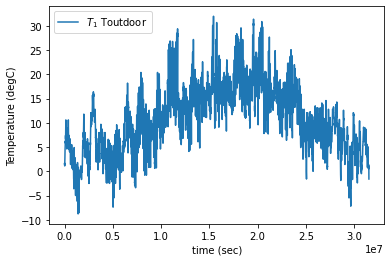

In [12]:
#numrows = len(input)    # 3 rows in your example
#numcols = len(input[0]) # 2 columns in your example

plt.plot(Tout[:,0],Toutdoor,label=r'$T_1$ Toutdoor')
plt.ylabel('Temperature (degC)')
plt.xlabel('time (sec)')
plt.legend(loc=2)

In [13]:
import gc
gc.collect() # collect garbages

8832

### Define input parameters

In [14]:
#window surface in m2
glass=[9.5,9.5,0,0,0,0,0,0]
#Window solar transmitance, g-value
g_value =0.7
#Time base on 1 hour sampling from NEN
time=qsunS[:,0]

In [15]:
print(len(time))

8760


1
8760


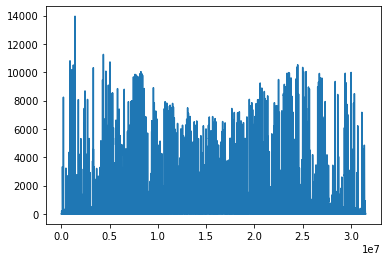

In [16]:
Qsolar = (qsunS[:,1]*glass[0] + qsunSW[:,1]*glass[1] + 
                      qsunW[:,1]*glass[2] + qsunNW[:,1]*glass[3] + 
                      qsunN[:,1]*glass[4] + qsunNE[:,1]*glass[5] + 
                      qsunE[:,1]*glass[6] + qsunSE[:,1]*glass[7]) * g_value
print(len(Qsolar[0]))
print(len(Qsolar))
plt.plot(time,Qsolar)

### Internal heat gain 

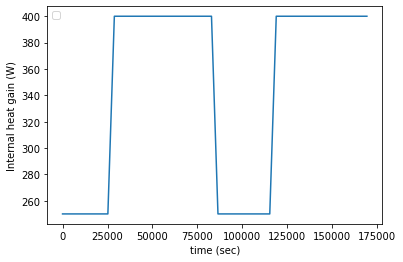

In [17]:
from scipy import signal

DeltaQ     = 150                     #Internal heat gain difference between day and night
#day_DeltaQ = DeltaQ                 #Day Delta Q internal [W]
Qday       = 400                     #Day internal heat gain W
nightQ     = Qday - DeltaQ           #Night internal heat gain

t1= 8                                #Presence from [hour]
t2= 23                               #Presence until [hour]

days_hours   = 24                    #number_of_hour_in_oneday + start hour at 0
days         = 365                   #number of simulation days
periods      = 24*3600*days          #in seconds (day_periods*365 = years)
pulse_width  = (t2-t1)/24            # % of the periods
phase_delay  = t1                    #in seconds


#t = np.linspace(0, 24*3600, 24)
t= np.linspace(0,1,(days_hours*days)+1,endpoint=False)          #+1 start from 0
pulseday = signal.square(2 * np.pi* days * t,duty=pulse_width)
pulseday = np.clip(pulseday, 0, 1)
# add delay to array
pulseday=np.roll(pulseday,phase_delay)

#______pulse week generator______________

week = days/7
pulse_w  = 0.99

#t = np.linspace(0, 24*3600, 24)
pulse_week = signal.square(2*np.pi*week*t,duty=pulse_w)
pulse_week = np.clip(pulse_week, 0, 1)

#pulse_week=np.roll(pulse_week,phase_delay)

#create simulation time
time_t = np.linspace(0,periods,(days_hours*days)+1)

#Internal heat gain

Qinternal = nightQ + pulseday*DeltaQ*pulse_week
Qinternal=Qinternal[np.newaxis]
Qinternal=Qinternal.T

#Plot 48 hours

plt.plot(time_t[0:48], Qinternal[0:48])
plt.ylabel('Internal heat gain (W)')
plt.xlabel('time (sec)')
plt.legend(loc=2)
#print(Qinternal)
Qinternal=np.delete(Qinternal, -1, 0)

>  Initialization Dwelling

    10 July 2018
    Arie Taal, Baldiri Salcedo HHS
    Missing Parameters: The incident solar heat is divided between Cwall and Cair by the  
    convection factor (CF=0.8)
    Qinst : Q (isntant  by heating or cooling needed) at this moments
    Last modify by Trung Nguyen

In [18]:
#Envelope surface (facade + roof + ground) [m2]
A_facade = 160.2
#Envelope thermal resitance, R-value [m2/KW]
Rc_facade =1.3
#Windows surface [N,S,E,W,SE,SW,NE,NW] [m2]
#glass =[0,0,9.5,9.5,0,0,0,0]
#Window thermal transmittance, U-value [W/m2K]
Uglass = 2.9
#Window solar transmitance, g-value
g_value =0.7
CF=0.8
#Ventilation, air changes per hour [#/h]
n=0.55
#Internal volume [m3]
V_dwelling = 275.6
#Facade construction
N_facade  = 2                  # Middle_weight =2 Light_weight =1 / Heavy_weight
#Floor and internal walls surface [m2]
A_internal_mass = 300
#Floor and internal walls construction
N_internal_mass = 2             # Middle_weight =2 / Light_weight=1 / Heavy_weight


# House model Initial Parameters

In [19]:
N_internal_mass = 2   # 1: Light weight construction / 2: Middle weight construction / 3: Heavy weight construction
N_facade = 2          # 1: Light weight construction / 2: Middle weight construction / 3: Heavy weight construction

In [20]:
#Initial parameters file for House model

##Predefined variables
 
rho_air = 1.20;              # density air in [kg/m3]
c_air  = 1005;               # specific heat capacity air [J/kgK]
alpha_i_facade = 8;
alpha_e_facade = 23;
alpha_internal_mass = 8;

#Variables from Simulink model, dwelling mask
#Floor and internal walls construction.
#It is possible to choose between light, middle or heavy weight construction

if N_internal_mass==1:          #Light weight construction 
    
    c_internal_mass=840         #Specific heat capacity construction [J/kgK]
    th_internal_mass=0.1        #Construction thickness [m]
    rho_internal_mass=500       #Density construction in [kg/m3]
      
elif N_internal_mass==2:       #Middle weight construction 
    
    c_internal_mass=840        # Specific heat capacity construction [J/kgK]
    th_internal_mass=0.1       # Construction thickness [m]
    rho_internal_mass=1000     # Density construction in [kg/m3]
     
else:                          #Heavy weight construction
         
    c_internal_mass=840        #Specific heat capacity construction [J/kgK]
    th_internal_mass=0.2       #Construction thickness [m]
    rho_internal_mass=2500     #Density construction in [kg/m3]   

# Facade construction
# It is possible to choose between light, middle or heavy weight construction

if N_facade==1:              # Light weight construction   
    
    c_facade=840             # Specific heat capacity construction [J/kgK]
    rho_facade=500           # Density construction in [kg/m3]
    th_facade=0.1            # Construction thickness [m] 

elif  N_facade==2:           # Middle weight construction       
    
    c_facade=840             # Specific heat capacity construction [J/kgK]
    rho_facade=1000          # Density construction in [kg/m3]
    th_facade=0.1            # Construction thickness [m]

else:                        # Heavy weight construction
    
    c_facade=840             # Specific heat capacity construction [J/kgK]
    rho_facade=2500          # Density construction in [kg/m3]
    th_facade=0.2            # Construction thickness [m]


Aglass=sum(glass)          # Sum of all glass surfaces [m2]

#Volume floor and internal walls construction [m3]

V_internal_mass=A_internal_mass*th_internal_mass  

# A_internal_mass:  Floor and internal walls surface [m2]

qV=(n*V_dwelling)/3600            # Ventilation, volume air flow [m3/s],  

# n: ventilation air change per hour;  V_dwelling : internal volume m3
qm=qV*rho_air;                     # Ventilation, mass air flow [kg/s]

#Dwelling temperatures calculation
#Calculation of the resistances

Rair_wall=1/(A_internal_mass*alpha_internal_mass)  # Resistance indoor air-wall
U=1/(1/alpha_i_facade+Rc_facade+1/alpha_e_facade)  # U-value indoor air-facade
Rair_outdoor=1/(A_facade*U+Aglass*Uglass+qm*c_air) # Resitance indoor air-outdoor air

# Calculation of the capacities
Cair = rho_internal_mass*c_internal_mass*V_internal_mass/2+ rho_air*c_air*V_dwelling # Capacity indoor air + walls
Cwall= rho_internal_mass*c_internal_mass*V_internal_mass/2                           # Capacity walls


> ## Define Temperature SP
    > Assume that in normal working day, people wake up at 7.00, go to work at 8.00
    return home at 18.00 and go to sleep at 23.00

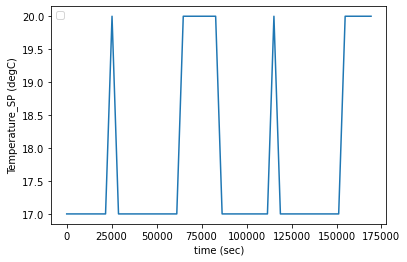

In [246]:
#Define Temperature SP for 1 days (24 hours)

Night_T_SP=17
Day_T_SP=20

#temperature different between day and night.
delta_T= Day_T_SP - Night_T_SP

# Define Wake up time
Wu_time =7           # wake up at 7 in the morning
duty_wu = 23-7       

# Go to work time/ leave the house
Work_time = 8           #go to work at 8 in the morning
duty_w   = 23-8        

# Back to home
back_home = 18         #back home at 18.00
duty_b   = 23-18 


#-----------------------
t= np.linspace(0,1,(days_hours*days)+1,endpoint=False)          #+1 start from 0 days=1
temp1 = signal.square(2 * np.pi* days * t,duty=duty_wu/24)
temp1 = np.clip(temp1, 0, 1)
# add delay to array
temp1=np.roll(temp1,Wu_time)

#----------------
t= np.linspace(0,1,(days_hours*days)+1,endpoint=False)          #+1 start from 0 days=1
temp2 = signal.square(2 * np.pi* days * t,duty=duty_w/24)
temp2 = np.clip(temp2, 0, 1)
# add delay to array
temp2=np.roll(temp2,Work_time)

#___________
t= np.linspace(0,1,(days_hours*days)+1,endpoint=False)          #+1 start from 0 days=1
temp3 = signal.square(2 * np.pi* days * t,duty=duty_b/24)
temp3 = np.clip(temp3, 0, 1)
# add delay to array
temp3=np.roll(temp3,back_home)

# Calculate SP
temp4=temp1-temp2+temp3
SP=(temp4*delta_T)+Night_T_SP

SP=SP[np.newaxis]
SP=SP.T

# Plot 48 hours
plt.plot(time_t[0:48], SP[0:48])
plt.ylabel('Temperature_SP (degC)')
plt.xlabel('time (sec)')
plt.legend(loc=2)
#print(Qinternal)
SP=np.delete(SP, -1, 0)


# Simulation

In [22]:
def weird_division(n, d):
    return n / d if d else 0

### Define Simulation time

In [146]:
#Define Simulation time

days_Sim = 20                          #number of simulation days

time_sim      = time[0:days_Sim*24]
Qsolar_Sim    = Qsolar[0:days_Sim*24] 
Qinternal_Sim = Qinternal[0:days_Sim*24]
#Qinst_Sim     = Qinst_Sim[0:days_Sim*24]
T_outdoor_Sim = T_outdoor[0:days_Sim*24]

#Set point
SP_Sim=SP[0:days_Sim*24]


In [24]:
print(len(T_outdoor_Sim))
print(len(Qsolar_Sim))
print(len(Qinternal_Sim))
print(len(SP_Sim))
print(len(time_sim))

480
480
480
480
480


In [97]:
m = GEKKO()
m.time = time_sim

# Parameters to Estimate
CF    = 0.8                     # Convection factor
#Heat controller

# Model Paramters Inputs

Qsolar_Sim    = m.Param(value=Qsolar_Sim)
Qinternal_Sim = m.Param(value=Qinternal_Sim)
#Qinst_Sim     = m.Param(value=Qinst_Sim)
T_outdoor_Sim = m.Param(value=T_outdoor_Sim) 
SP_Sim        = m.Param(value=SP_Sim)

# Model Process Variables
Tair = m.Var(value=20)          
Twall = m.Var(value=20)
#Qinst_Sim = m.Var(value=0)
#Qinst_Sim = 0                   

#_______PID Controller______

kP   = 10000
tauI = 0
tauD = 0

Qinst_0 = 0                           #Output Variables, Initial heating output
Qinst = m.Var(value=0)
#PV=m.Var(value=0)
err=m.Intermediate(SP_Sim-Tair) 
Integl= m.Var(value=0)


# Equations

m.Equation(Qinst==Qinst_0 + kP*err + weird_division(kP,tauI)* Integl +kP*tauD*Tair.dt()) # PID form
m.Equation(Integl.dt()==err )
m.Equation(Cair * Tair.dt()   == (T_outdoor_Sim-Tair)/Rair_outdoor + (Twall-Tair)/Rair_wall  + Qinst + Qinternal_Sim + CF*Qsolar_Sim)
m.Equation(Cwall * Twall.dt() == (Tair-Twall)/Rair_wall + (1-CF)*Qsolar_Sim)

#Control Variables


# Equations
#m.Equation(Cair * Tair.dt()   == (T_outdoor-Tair)/Rair_outdoor + (Twall-Tair)/Rair_wall + Qinst + Qinternal + CF*Qsolar)
#m.Equation(Cwall * Twall.dt() == (Tair-Twall)/Rair_wall + (1-CF)*Qsolar)

# Global Options
m.options.IMODE   = 5 # MHE
#m.options.EV_TYPE = 2 # Objective type
m.options.NODES   = 2 # Collocation nodes
m.options.SOLVER  = 3 # IPOPT

#------------------------------------------
m.solve(disp=False)

Exception:  @error: Solution Not Found


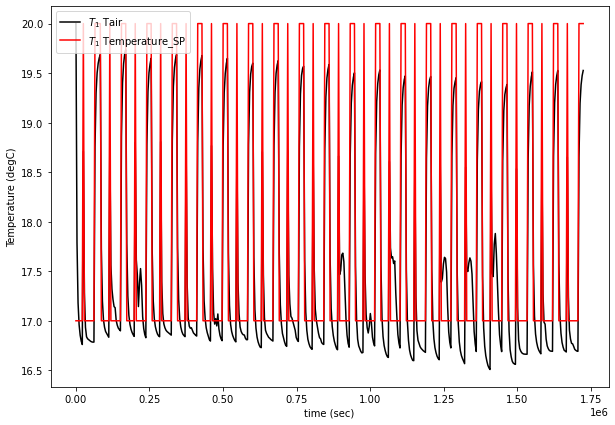

In [92]:
# Create plot
plt.figure(figsize=(10,7))
plt.plot(time_sim,Tair.value,'k-',label=r'$T_1$ Tair')
#plt.plot(time_sim,Twall.value,'k-',label=r'$T_1$ Tair')

#plt.plot(time_sim,T_outdoor_Sim,'r-',label=r'$T_1$ Toutdoor')
plt.plot(time_sim,SP_Sim,'r-',label=r'$T_1$ Temperature_SP')

#plt.plot(m.time[56:72],u[56:72],'b.-')


plt.ylabel('Temperature (degC)')
plt.xlabel('time (sec)')
plt.legend(loc=2)

In [360]:
#Define Simulation time

days_Sim = 20                          #number of simulation days

time_sim      = time[0:days_Sim*24][:,0]
Qsolar_Sim    = Qsolar[0:days_Sim*24][:,0] 
Qinternal_Sim = Qinternal[0:days_Sim*24][:,0]
#Qinst_Sim     = Qinst_Sim[0:days_Sim*24][:,0]
T_outdoor_Sim = T_outdoor[0:days_Sim*24][:,0]

#Set point
SP_Sim=SP[0:days_Sim*24][:,0]

In [361]:
from scipy.integrate import odeint
import math
import pandas as pd 


kP = 10000
ki = 0
kd = 0

# Devide by zero function
def weird_division(n, d):
    return n / d if d else 0


#Define model
def House_Tem(x,t,T_outdoor_Sim,Qinternal_Sim,Qsolar_Sim,SP_T):
    
    # Inputs (8):
    
    # Isolar         : Solar Irradiation [W/m2]
    # Toutside       : Outside temperature [K]
    # FP             : Pump 1 Flow [m3/s]
    # Ftap           : Tap water flow  [m3/s]
    # TSTCin = T     : Tank tempearature out with delay [K]
    # THEin  = TSTC4 : Solar collector temperature with delay [K]
    # Tfloor         : Water temperature output from Floor  [K]
    #FP2             : Pump 2 Flow [m3/s]
    

# States :
    
    Tair            = x[0]   # Temperature Buffer Tank (K)
    Twall           = x[1]   # Return Temperature to Floor (K)
    integal         = x[2]
    #Qinstdt         = x[2]
    
    err      = SP_T-Tair
    integaldt= err
    integald= np.clip(integaldt, 0, 5)
    Qinst    = kP*(err) + ki*integal # kd*Tair.dt() # PID form
    Qinst=np.clip(Qinst, 0, 7000)
    #m.Equation(Integl.dt()==err )
    Tairdt   = ((T_outdoor_Sim-Tair)/Rair_outdoor + (Twall-Tair)/Rair_wall  + Qinst + Qinternal_Sim + CF*Qsolar_Sim)/Cair
    Twalldt  = ((Tair-Twall)/Rair_wall + (1-CF)*Qsolar_Sim)/Cwall
    
    # Return 
    return [Tairdt,Twalldt,integaldt]

# Initial Conditions for the States
    
#Solar Collector
Tair0    = 20   
Twall0   = 20
integal0=0

y0 = [Tair0,Twall0,integal0]

# Time Interval (sec)
#t = np.linspace(0,60*60,days_Sim*24)  # Define Simulation time with resolution
#time_sim      = time[0:days_Sim*24]
t = time_sim           # Define Simulation time with sampling time

# Model Paramters Inputs

Qsolar_Sim    =  Qsolar_Sim
Qinternal_Sim =  Qinternal_Sim
#Qinst_Sim     = m.Param(value=Qinst_Sim)
#SP_Sim        = SP_Sim


# Outside Temperature (K)
#T_outdoor_Sim = np.ones(len(t))* 15
T_outdoor_Sim =T_outdoor_Sim
#Toutside[50:] = 283


Tair  = np.ones(len(t))*Tair0
Twall  = np.ones(len(t))*Twall0
integal= np.ones(len(t))*integal0
Qinst = np.zeros(len(t))
SP_T=SP_Sim
#SP_T= np.ones(len(t))*20


for i in range(len(t)-1):
    
    inputs = (T_outdoor_Sim[i],Qinternal_Sim[i],Qsolar_Sim[i],SP_T[i])
    ts = [t[i],t[i+1]]
    y = odeint(House_Tem,y0,ts,args=inputs)
    # Store results
    
#delatat is a delay base on distance between buffer tank and Solar Collector    
    #deltat    = rp**(2)*pi*lp/(FP[i+1])
    
    Tair[i+1]         = y[-1][0]
    Twall[i+1]         = y[-1][1]
    integal[i+1]         = y[-1][2]

    # Adjust initial condition for next loop
    y0 = y[-1]
    
# Construct results and save data file
data = np.vstack((t,Tair,Twall,integal)) # vertical stack
#data = data.T             # transpose data
np.savetxt('data.txt',data,delimiter=',')
#print(Tair)


In [362]:
Qinst    = kP*(SP_T-Tair) + ki*integal # kd*Tair.dt() # PID form
Qinst=np.clip(Qinst, 0, 7000)

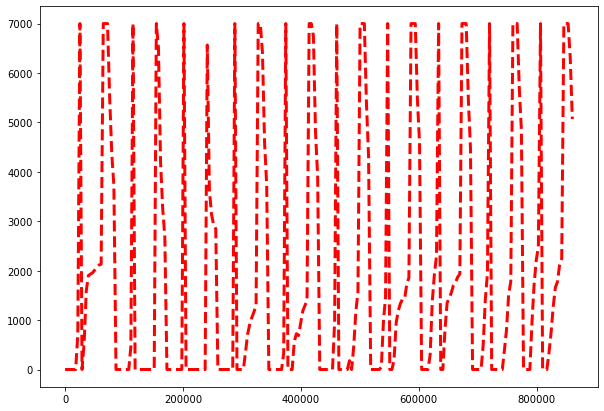

In [363]:
# Plot the inputs and results
plt.figure(figsize=(10,7))
#plt.plot(t,TSTC4,'k--',linewidth=3)
#plt.plot(t,THE4,'b--',linewidth=3)
plt.plot(t,Qinst,'r--',linewidth=3)

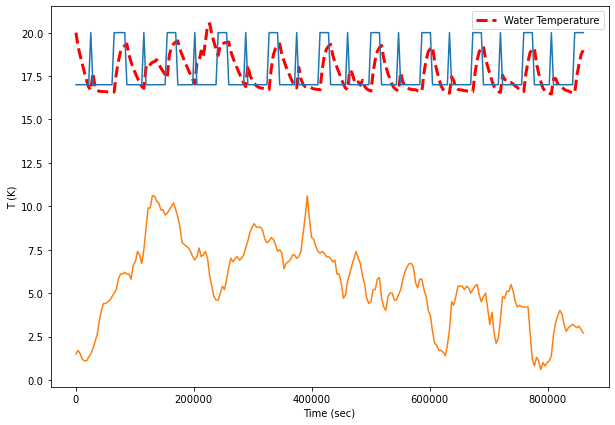

<Figure size 432x288 with 0 Axes>

In [365]:
# Plot the inputs and results
plt.figure(figsize=(10,7))
#plt.plot(t,TSTC4,'k--',linewidth=3)
#plt.plot(t,THE4,'b--',linewidth=3)
plt.plot(t,Tair,'r--',linewidth=3)
plt.plot(t,SP_T) #Qsolar_Sim
#plt.plot(t,(Qsolar_Sim*0.001+18)) #Qsolar_Sim
#plt.plot(t,(Qinst*0.001+18)) #Qsolar_Sim

plt.plot(t,T_outdoor_Sim) #Qsolar_Sim

#plt.plot(t,THES4,'g--',linewidth=3)
plt.ylabel('T (K)')
plt.legend(['Water Temperature'],loc='best')
plt.xlabel('Time (sec)')
plt.figure()
plt.show()

In [33]:
#!pip list

